# Frost App Correction

## Introduction

### Aim

The goal is to build a Streamlit app that will display the number of frost days for a given city in France computed over a decade. The data is provided by Météo France. It will eventually help winegrowers and farmers to make better decisions.

For each day of the year, we want to know how many times the minimum temperature was below 0°C.

### Objectives

This notebook will show you the process of finding the closest weather stations to each city in France. More than code, it will explain the reasoning behind each step. Building an app that uses data means also one must analyze and understand the data. If you don't and just copy paste code from LLMs, many mistakes, sometimes hard to spot, will be made.

In [1]:
# Import. Each time we need a new library, we add it in this cell.

# we want to reload all the imports each time we run a cell
# so that we don't have to restart the kernel each time we change a library
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from func import *

In [2]:
# Constants. Each time we need a new constant, we add it in this cell.
# At the end we can all copy/paste them in a config.py file.
RAW_DATA_PATH = "data/raw"
PROCESSED_DATA_PATH = "data/processed"
START_DATE = 2014
END_DATE = 2023
DEFAULT_WEATHER_FILENAME = "Q_13_previous-1950-2023_RR-T-Vent.csv.gz"
COMPLETION_RATE_THRESHOLD = 0.65
DEFAULT_WEATHER_URL = "https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/"

## Weather data

### Download the data

You can read the data directly from the URL but when you build and test the app, it is better to have a local copy of the data. So we will download the data and save it in the `data/raw` folder. Our test file will be a small subset of the data, the department 13 (Bouches-du-Rhône).

-> Download the data from (https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_13_previous-1950-2023_RR-T-Vent.csv.gz) and save it in `data/raw/Q_13_previous-1950-2023_RR-T-Vent.csv.gz`.

Let's also add a constant DEFAULT_WEATHER_FILENAME so we can change the filename easily.

In [3]:
# Creates the directory if it does not exist
os.makedirs(RAW_DATA_PATH, exist_ok=True)

url = os.path.join(DEFAULT_WEATHER_URL, DEFAULT_WEATHER_FILENAME)

# Download the file if it does not exist
if not os.path.exists(os.path.join(RAW_DATA_PATH, DEFAULT_WEATHER_FILENAME)):
    os.system(
        f"wget -O {os.path.join(RAW_DATA_PATH, DEFAULT_WEATHER_FILENAME)} {url}"
    )

### GIT and data

To avoid committing large files to git ( size superior to 10Mo), we will use a .gitignore file.
If you don't have one already, create a file named `.gitignore` in the root of your project and add the following lines:
```
# Ignore data files
data/
```

### Analysis of the weather data

#### Data loading and overview


In [4]:
weather_df = pd.read_csv(
    os.path.join(RAW_DATA_PATH, DEFAULT_WEATHER_FILENAME),
    compression="gzip",)

weather_df.head(5)

,NUM_POSTE;NOM_USUEL;LAT;LON;ALTI;AAAAMMJJ;RR;QRR;TN;QTN;HTN;QHTN;TX;QTX;HTX;QHTX;TM;QTM;TNTXM;QTNTXM;TAMPLI;QTAMPLI;TNSOL;QTNSOL;TN50;QTN50;DG;QDG;FFM;QFFM;FF2M;QFF2M;FXY;QFXY;DXY;QDXY;HXY;QHXY;FXI;QFXI;DXI;QDXI;HXI;QHXI;FXI2;QFXI2;DXI2;QDXI2;HXI2;QHXI2;FXI3S;QFXI3S;DXI3S;QDXI3S;HXI3S;QHXI3S;DRR;QDRR
0,13001002;AIX-PUYRICARD;43.593333;5.413333;314;...
1,13001002;AIX-PUYRICARD;43.593333;5.413333;314;...
2,13001002;AIX-PUYRICARD;43.593333;5.413333;314;...
3,13001002;AIX-PUYRICARD;43.593333;5.413333;314;...
4,13001002;AIX-PUYRICARD;43.593333;5.413333;314;...


The separator in the data is a semicolon `;` and not a comma `,`. So we need to specify that when reading the data with pandas.

In [5]:
weather_df = pd.read_csv(
    os.path.join(RAW_DATA_PATH, DEFAULT_WEATHER_FILENAME),
    compression="gzip",
    sep=';')

weather_df.head(5)

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR
0,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620701,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620702,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620703,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620704,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13001002,AIX-PUYRICARD,43.593333,5.413333,314,19620705,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
weather_df.shape

(1202310, 58)

In [7]:
weather_df.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'QRR',
       'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM',
       'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50',
       'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY',
       'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI',
       'QHXI', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S',
       'QFXI3S', 'DXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR'],
      dtype='object')

#### Reading the documentation

If you read the documentation (also called metadata) located [here](https://object.files.data.gouv.fr/meteofrance/data/synchro_ftp/BASE/QUOT/Q_descriptif_champs_RR-T-Vent.csv). You will see that the columns of interest are:

```
NUM_POSTE   : numéro Météo-France du poste sur 8 chiffres
NOM_USUEL   : nom usuel du poste
LAT         : latitude, négative au sud (en degrés et millionièmes de degré)
LON         : longitude, négative à l’ouest de GREENWICH (en degrés et millionièmes de degré)
ALTI        : altitude du pied de l'abri ou du pluviomètre si pas d'abri (en m)
AAAAMMJJ    : date de la mesure (année mois jour)
TN          : température minimale sous abri (en °C et 1/10)
```
 But also maybe :

 ```
TNSOL       : température quotidienne minimale à 10 cm au-dessus du sol (en °C et 1/10)
TN50        : température quotidienne minimale à 50 cm au-dessus du sol (en °C et 1/10)
```

Let's reimport the data with the right columns

In [8]:
d = {
    'NUM_POSTE': (str, 'station_id'),
    'NOM_USUEL': (str, 'station_name'),
    'LAT': (float, 'latitude'),
    'LON': (float, 'longitude'),
    'ALTI': (float, 'alti'),
    'AAAAMMJJ': (str, 'date'),
    'TN': (float, 'tmin'),
    'TNSOL': (float, 'tmin_ground'),
    'TN50': (float, 'tmin_50cm'),
}

weather_df = pd.read_csv(os.path.join(RAW_DATA_PATH, DEFAULT_WEATHER_FILENAME),
                           compression="gzip",
                           sep=';',
                           usecols=d.keys(),
                           dtype={k: v[0] for k, v in d.items()},
                           ).rename(columns={k: v[1] for k, v in d.items()})

# Let's parse the date column
# We can technically do it in the read_csv function with the parse_dates argument
# but we have a better control if we do it in a separate step

weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')

weather_df.dtypes

station_id              object
station_name            object
latitude               float64
longitude              float64
alti                   float64
date            datetime64[ns]
tmin                   float64
tmin_ground            float64
tmin_50cm              float64
dtype: object

In [9]:
weather_df.head(5)

,station_id,station_name,latitude,longitude,alti,date,tmin,tmin_ground,tmin_50cm
0,13001002,AIX-PUYRICARD,43.593333,5.413333,314.0,1962-07-01,NaN,NaN,NaN
1,13001002,AIX-PUYRICARD,43.593333,5.413333,314.0,1962-07-02,NaN,NaN,NaN
2,13001002,AIX-PUYRICARD,43.593333,5.413333,314.0,1962-07-03,NaN,NaN,NaN
3,13001002,AIX-PUYRICARD,43.593333,5.413333,314.0,1962-07-04,NaN,NaN,NaN
4,13001002,AIX-PUYRICARD,43.593333,5.413333,314.0,1962-07-05,NaN,NaN,NaN


#### Temperatures analysis

A lot of the values in the temperature columns seem empty. Let's see how many values are missing.



In [10]:
weather_df.shape

(1202310, 9)

In [11]:
# Check for missing values in the dataframe
weather_df.isnull().sum()

station_id            0
station_name          0
latitude              0
longitude             0
alti                  0
date                  0
tmin             553861
tmin_ground     1057145
tmin_50cm       1186985
dtype: int64

In [12]:
# Check for percentage of missing values in the dataframe
weather_df.isnull().mean() * 100

station_id       0.000000
station_name     0.000000
latitude         0.000000
longitude        0.000000
alti             0.000000
date             0.000000
tmin            46.066406
tmin_ground     87.926159
tmin_50cm       98.725370
dtype: float64

#### Slice the dataframe to keep only the data from 2014 to 2023

A lot of values are missing, but maybe it is only for the old data. Let's slice the dataframe to keep only the data from 2014 to 2023.

In [13]:
# Slicing the dataframe to keep only the data from 2014 to 2023
weather_df = weather_df.loc[weather_df['date'].dt.year.between(START_DATE, END_DATE, inclusive='both')]

In [14]:
# Now let's check again for missing values in the dataframe
weather_df.isnull().mean() * 100

station_id       0.000000
station_name     0.000000
latitude         0.000000
longitude        0.000000
alti             0.000000
date             0.000000
tmin            25.643913
tmin_ground     62.098364
tmin_50cm       95.888189
dtype: float64

#### Assessing data quality

The columns 'tmin_ground' and 'tmin_50cm' have a very high percentage of missing values. We will not use them in our analysis. The column 'tmin' has only   bout 25% of missing values, which is acceptable for our analysis.

Let's check how the number of missing values evolves over the years.

In [15]:
(
weather_df['tmin'].groupby(weather_df['date'].dt.year)
                  .apply(lambda x: x.isnull().mean() * 100)
)

date
2014    38.202953
2015    33.933135
2016    35.281478
2017    35.982897
2018    35.330329
2019    23.526825
2020    19.982510
2021    16.681891
2022     4.712179
2023     4.763148
Name: tmin, dtype: float64

In [16]:
# Create a bar chart showing the percentage of missing values over time with the number of stations in activity each year
import matplotlib.pyplot as plt
import seaborn as sns

missing_values = (weather_df['tmin'].groupby(weather_df['date'].dt.year)
                  .apply(lambda x: x.isnull()
                         .mean() * 100))

# Get the number of stations in activity each year
stations_in_activity = weather_df['station_id'].groupby(weather_df['date'].dt.year).nunique()

# Create a dataframe to hold the missing values and stations in activity
missing_values_df = pd.DataFrame({'missing_values': missing_values, 'stations_in_activity': stations_in_activity})

missing_values_df

,missing_values,stations_in_activity
date,,
2014,38.202953,27
2015,33.933135,26
2016,35.281478,26
2017,35.982897,25
2018,35.330329,25
2019,23.526825,25
2020,19.982510,25
2021,16.681891,24
2022,4.712179,21


In [17]:
#Create a function that returns a dataframe showing the percentage of missing values over time with the number of stations in activity each year
def compute_missing_values_over_time(df):
    missing_values = (df['tmin'].groupby(df['date'].dt.year)
                      .apply(lambda x: x.isnull()
                             .mean() * 100))

    # Get the number of stations in activity each year
    stations_in_activity = df['station_id'].groupby(df['date'].dt.year).nunique()

    # Create a dataframe to hold the missing values and stations in activity
    missing_values_df = pd.DataFrame({'missing_values': missing_values,
                                      'stations_in_activity': stations_in_activity})
    
    return missing_values_df

compute_missing_values_over_time(weather_df)

,missing_values,stations_in_activity
date,,
2014,38.202953,27
2015,33.933135,26
2016,35.281478,26
2017,35.982897,25
2018,35.330329,25
2019,23.526825,25
2020,19.982510,25
2021,16.681891,24
2022,4.712179,21


In [18]:
# OPTIONAL : USE .agg instead of .apply

#Create a function that returns a dataframe showing the percentage of missing values over time with the number of stations in activity each year
def missing_values_over_time_with_agg(df):
    missing_values_df = (df.groupby(df['date'].dt.year)
                      .agg({'tmin': lambda x: x.isnull().mean() * 100,
                           'station_id': 'nunique'})).rename(columns={'tmin': 'missing_values',
                                                                 'station_id': 'stations_in_activity'})
    return missing_values_df
missing_values_over_time_with_agg(weather_df).equals(compute_missing_values_over_time(weather_df))

# Once it's working and the function is copied in func.py, we can delete this cell.

True

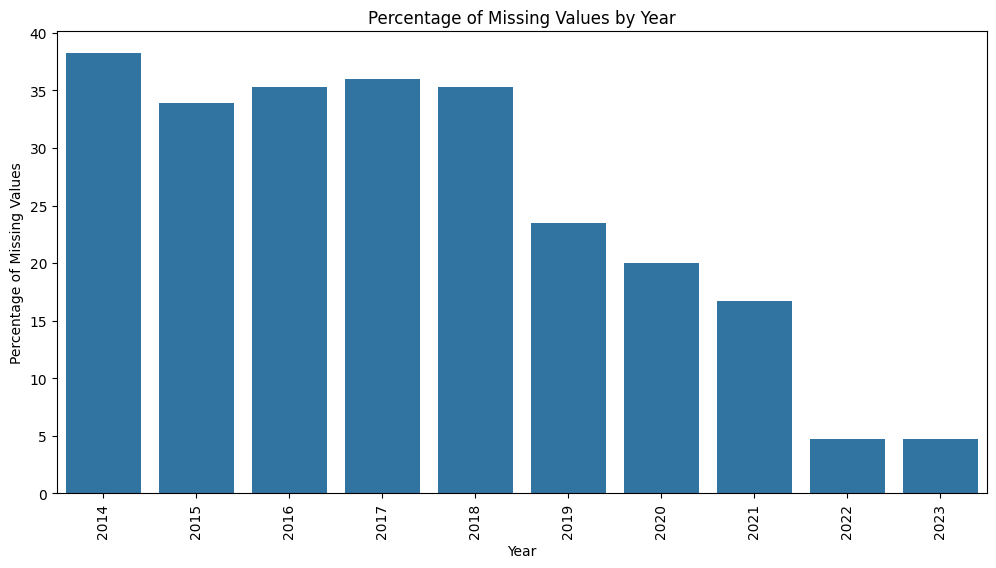

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=90)
plt.title('Percentage of Missing Values by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of Missing Values')
plt.show()

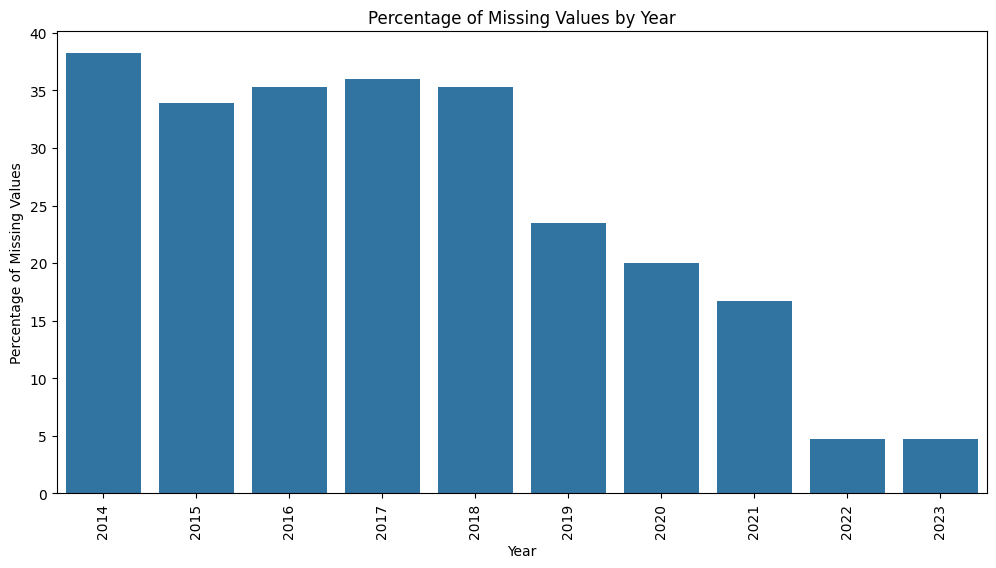

In [20]:
# To add in func.py

def plot_missing_values_and_stations(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=df.index, y=df['missing_values'])
    plt.xticks(rotation=90)
    plt.title('Percentage of Missing Values by Year')
    plt.xlabel('Year')
    plt.ylabel('Percentage of Missing Values')
    plt.show()
plot_missing_values_and_stations(missing_values_over_time_with_agg(weather_df))

# and then delete this cell

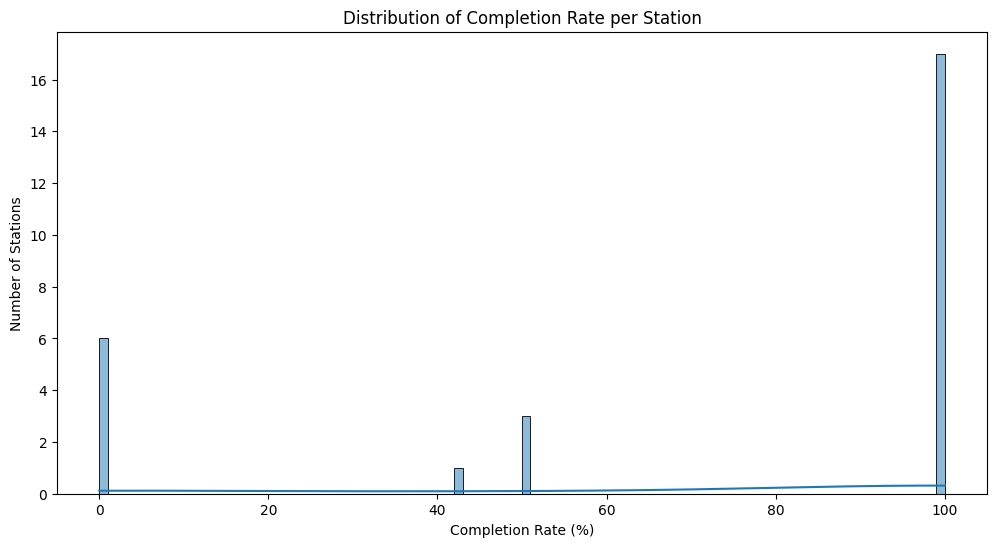

In [21]:
# Display the distribution of completion rate per station
completion_rate = weather_df.groupby('station_id')['tmin'].apply(lambda x: x.notnull().mean() * 100)
plt.figure(figsize=(12, 6))
sns.histplot(completion_rate, bins=100, kde=True)
plt.title('Distribution of Completion Rate per Station')
plt.xlabel('Completion Rate (%)')
plt.ylabel('Number of Stations')
plt.show()

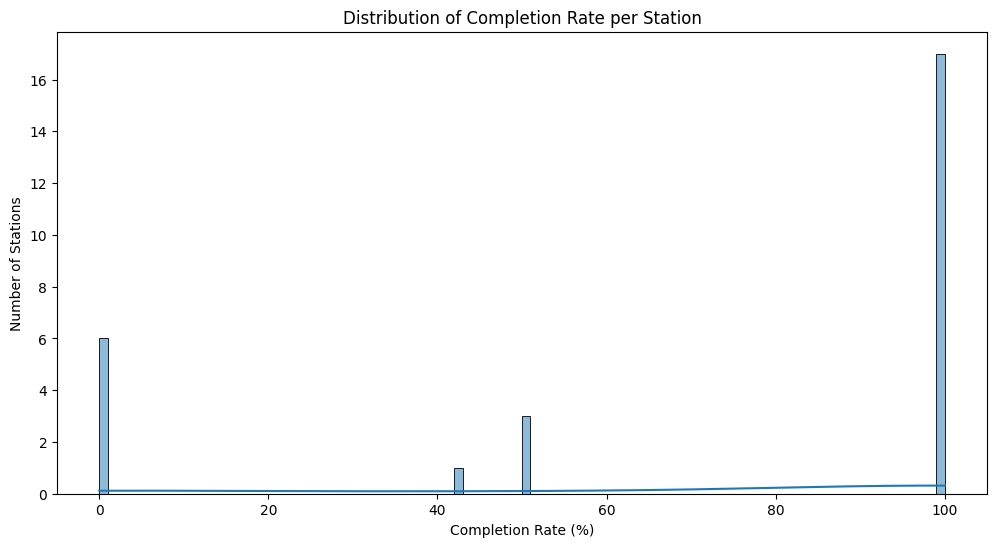

In [ ]:
# Let's make it a function to add in func.py
def plot_completion_rate_distribution(df: pd.DataFrame):
    completion_rate = df.groupby('station_id')['tmin'].apply(lambda x: x.notnull().mean() * 100)
    plt.figure(figsize=(12, 6))
    sns.histplot(completion_rate, bins=100, kde=True)
    plt.title('Distribution of Completion Rate per Station')
    plt.xlabel('Completion Rate (%)')
    plt.ylabel('Number of Stations')
    plt.show()
    
plot_completion_rate_distribution(weather_df)

Now we have a better idea of the data quality, as far as the department 13 (Bouches-du-Rhône) is concerned. Let's say a completion rate over 65% is acceptable.

In [23]:
completion_rate = weather_df.groupby('station_id')['tmin'].apply(lambda x: x.notnull().mean()) # we remove the * 100 to keep it between 0 and 1
valid_stations = completion_rate[completion_rate >= COMPLETION_RATE_THRESHOLD].index # COMPLETION_RATE_THRESHOLD is between 0 and 1
weather_df = weather_df[weather_df['station_id'].isin(valid_stations)]

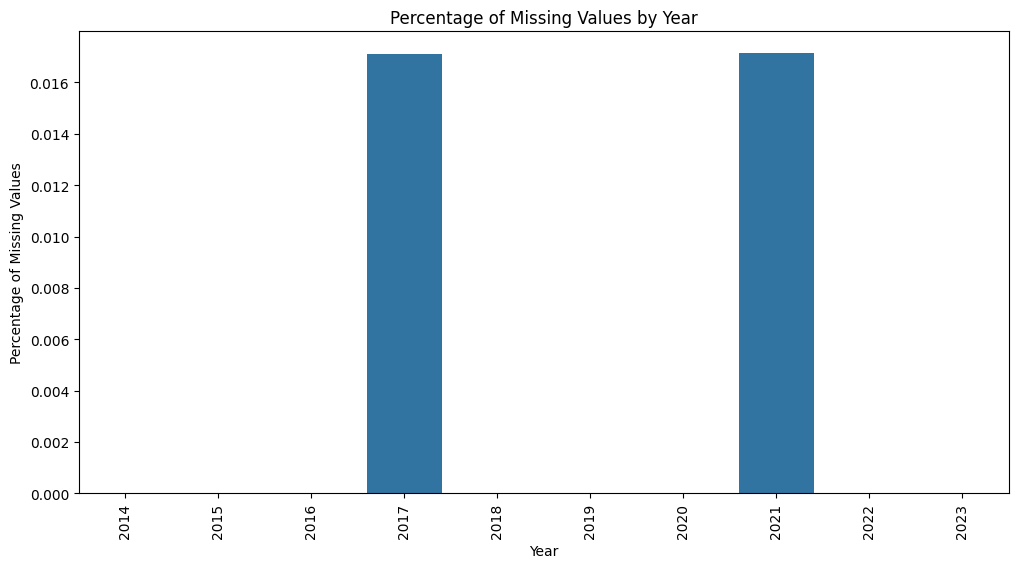

In [24]:
plot_missing_values_and_stations(compute_missing_values_over_time(weather_df))

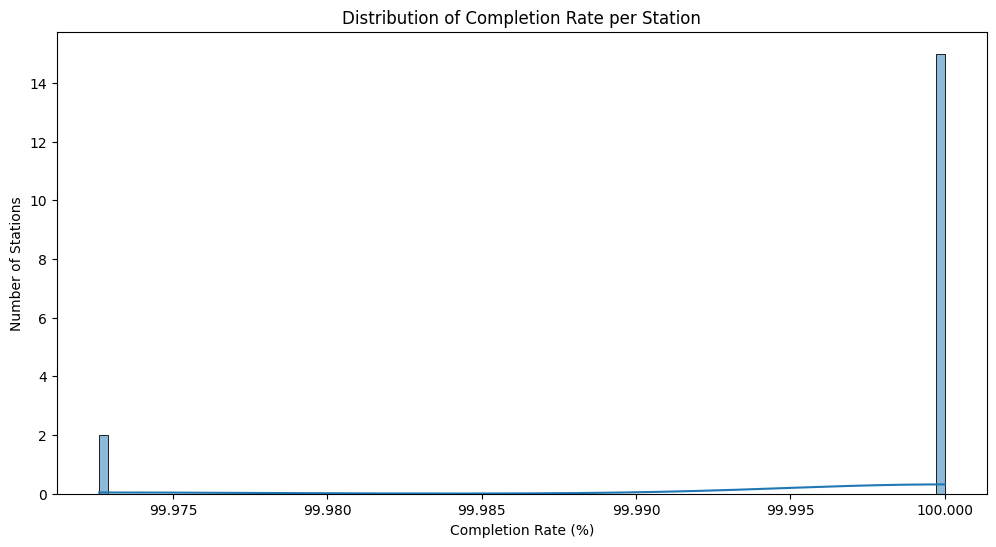

In [25]:
plot_completion_rate_distribution(weather_df)

### Custom functions

Let's create a function that will open a file with pandas, set the right dtypes, slice the dataframe to keep only the data from the start and end date, and remove all observations from stations that have a completion rate lower than the threshold.

In [ ]:
# Let's create a function that will open a file with pandas, set the right dtypes,
# slice the dataframe to keep only the data from the start and end date,
# and remove all observations from stations that have a completion rate lower than the threshold.
def process_weather_data(
                         dept: str,
                         local_file: bool=False,
                         start_date: str=START_DATE,
                         end_date: str=END_DATE,
                         completion_rate_threshold: float=COMPLETION_RATE_THRESHOLD,
                         remove_stations_below_threshold: bool=True,
                         raw_data_path: str=RAW_DATA_PATH,
                         default_url: str=DEFAULT_WEATHER_URL,
                         ):

    filename = f"Q_{dept}_previous-1950-2023_RR-T-Vent.csv.gz"
    if local_file:
        weather_filename = os.path.join(raw_data_path, filename)
    else:
        weather_filename = f"{default_url}{filename}"

    d = {
        'NUM_POSTE': (str, 'station_id'),
        'NOM_USUEL': (str, 'station_name'),
        'LAT': (float, 'latitude'),
        'LON': (float, 'longitude'),
        'ALTI': (float, 'alti'),
        'AAAAMMJJ': (str, 'date'),
        'TN': (float, 'tmin'),
    }

    weather_df = pd.read_csv(weather_filename,
                            compression="gzip",
                            sep=';',
                            usecols=d.keys(),
                            dtype={k: v[0] for k, v in d.items()},
                            ).rename(columns={k: v[1] for k, v in d.items()})

    weather_df['date'] = pd.to_datetime(weather_df['date'], format='%Y%m%d')
    
    # Slice the dataframe to keep only the data from start_date to end_date
    weather_df = weather_df.loc[weather_df['date'].dt.year.between(start_date, end_date, inclusive='both')]

    # Remove all observations from stations that have a completion rate lower than the threshold
    if remove_stations_below_threshold:
        completion_rate = weather_df.groupby('station_id')['tmin'].apply(lambda x: x.notnull().mean())
        valid_stations = completion_rate[completion_rate >= completion_rate_threshold].index
        weather_df = weather_df[weather_df['station_id'].isin(valid_stations)]

    return weather_df

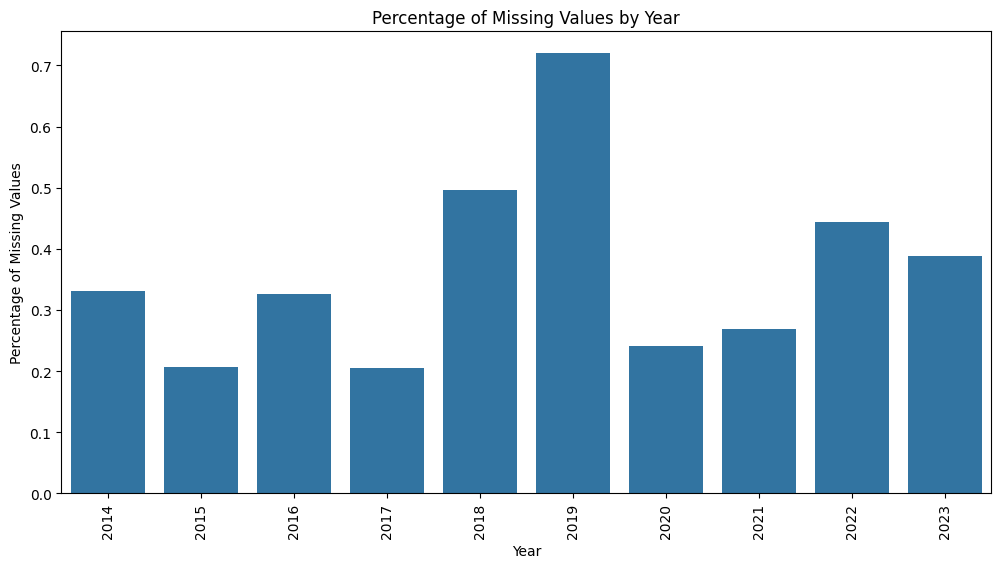

In [27]:
_df = process_weather_data(dept='04', remove_stations_below_threshold=True)
plot_missing_values_and_stations(compute_missing_values_over_time(_df))

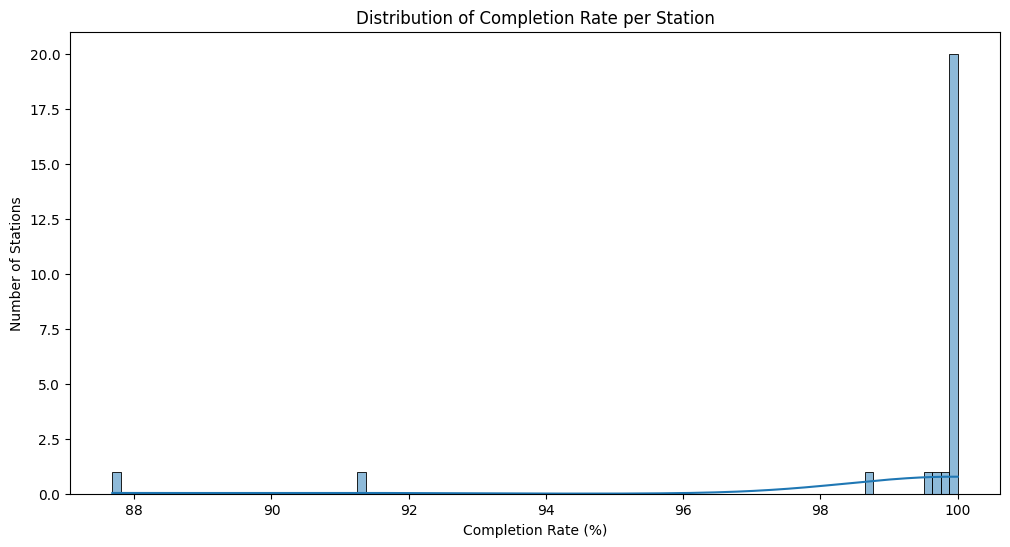

In [28]:
plot_completion_rate_distribution(_df)

## Cities data

### Download cities

https://www.data.gouv.fr/datasets/communes-et-villes-de-france-en-csv-excel-json-parquet-et-feather/

In [ ]:
# Download the file in data/raw

# Creates the directory if it does not exist
os.makedirs(RAW_DATA_PATH, exist_ok=True)

filename = 'communes-france-2025.csv.gz'
url = "https://www.data.gouv.fr/api/1/datasets/r/6989ed1a-8ffb-4ef9-b008-340327c99430"

# Download the file if it does not exist
os.system(f"wget -O {os.path.join(RAW_DATA_PATH, filename)} {url}") # Should work on linux and macOS


--2025-09-25 13:24:01--  https://www.data.gouv.fr/api/1/datasets/r/6989ed1a-8ffb-4ef9-b008-340327c99430
Resolving www.data.gouv.fr (www.data.gouv.fr)... 37.59.183.91, 37.59.183.73
Connecting to www.data.gouv.fr (www.data.gouv.fr)|37.59.183.91|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://static.data.gouv.fr/resources/communes-et-villes-de-france-en-csv-excel-json-parquet-et-feather/20250221-162608/communes-france-2025.csv.gz [following]
--2025-09-25 13:24:01--  https://static.data.gouv.fr/resources/communes-et-villes-de-france-en-csv-excel-json-parquet-et-feather/20250221-162608/communes-france-2025.csv.gz
Resolving static.data.gouv.fr (static.data.gouv.fr)... 37.59.183.73, 37.59.183.91
Connecting to static.data.gouv.fr (static.data.gouv.fr)|37.59.183.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3076423 (2,9M) [application/octet-stream]
Saving to: ‘data/raw/communes-france-2025.csv.gz’

     0K .......... ........

0

### Loading and analysing cities data

In [30]:
# Load the communes df
d = {
    "code_insee": ["string", "insee_code"],
    "nom_standard": ["string", "name"],
    "dep_code": ["string", "dep_code"],
    "dep_nom": ["string", "dep_name"],
    "latitude_centre": ["float32", "lat"],
    "longitude_centre": ["float32", "lon"],
}

city_df = pd.read_csv(
    "data/raw/communes-france-2025.csv.gz",
    compression="gzip",
    usecols=d.keys(),
    dtype={k: v[0] for k, v in d.items()},
).rename(columns={k: v[1] for k, v in d.items()})#.dropna()

city_df.head(5)

,insee_code,name,dep_code,dep_name,lat,lon
0,01001,L'Abergement-Clémenciat,01,Ain,46.153000,4.926
1,01002,L'Abergement-de-Varey,01,Ain,46.008999,5.428
2,01004,Ambérieu-en-Bugey,01,Ain,45.960999,5.373
3,01005,Ambérieux-en-Dombes,01,Ain,45.995998,4.912
4,01006,Ambléon,01,Ain,45.750000,5.594


### Department list

But first let's create a list of all the departments in France. A department is identified by its code, which is a string. The number "04" must have a zero in front of it.

In [31]:
def adds_zero_if_needed(x: int) -> str:
    if x < 10: return '0' + str(x)
    else: return str(x)

In [32]:
# Or with a lambda function
lambda x: str(x) if x >= 10 else '0' + str(x)

<function __main__.<lambda>(x)>

In [33]:
dept_list = [adds_zero_if_needed(dept) for dept in range(1, 96)]

### Missing values in city_df

In [34]:
# What happens if you use dropna() ?
#city_df[city_df['insee_code'].str.contains('13055')]

In [35]:
# display the cities that have missing values
missing_cities = city_df[city_df.isnull().any(axis=1)]
missing_cities

,insee_code,name,dep_code,dep_name,lat,lon
4342,13055,Marseille,13,Bouches-du-Rhône,NaN,NaN
20117,55138,Culey,55,Meuse,NaN,NaN
23101,60694,Les Hauts-Talican,60,Oise,NaN,NaN
27082,69123,Lyon,69,Rhône,NaN,NaN
29244,75056,Paris,75,Paris,NaN,NaN
29328,76095,Bihorel,76,Seine-Maritime,NaN,NaN
29810,76601,Saint-Lucien,76,Seine-Maritime,NaN,NaN
32700,85165,L'Oie,85,Vendée,NaN,NaN
32739,85212,Sainte-Florence,85,Vendée,NaN,NaN


In [36]:
# decimal degrees in the WGS84 coordinate system
missing_cities_lat_lon = {
    "Marseille": [43.295, 5.372],
    "Paris": [48.866, 2.333],
    "Culey": [48.755, 5.266],
    "Les Hauts-Talican": [49.3436, 2.0193],
    "Lyon": [45.75, 4.85],
    "Bihorel": [49.4542, 1.1162],
    "Saint-Lucien": [48.6480, 1.6229],
    "L'Oie": [46.7982, -1.1302],
    "Sainte-Florence": [46.7965, -1.1520],
}
# Modify the dataframe to fill in the missing lat/lon values
for city, (lat, lon) in missing_cities_lat_lon.items():
    city_df.loc[city_df["name"] == city, "lat"] = lat
    city_df.loc[city_df["name"] == city, "lon"] = lon

In [ ]:
# Let's make a function that does all the cleaning process with cities_city_df
def process_cities_data(raw_data_path: str=RAW_DATA_PATH,
                        filename: str='communes-france-2025.csv.gz',
                        dept_list: list|None=None,):
    d = {
        "code_insee": ["string", "insee_code"],
        "nom_standard": ["string", "name"],
        "dep_code": ["string", "dep_code"],
        "dep_nom": ["string", "dep_name"],
        "latitude_centre": ["float32", "lat"],
        "longitude_centre": ["float32", "lon"],
    }

    city_df = pd.read_csv(
        os.path.join(raw_data_path, filename),
        compression="gzip",
        usecols=d.keys(),
        dtype={k: v[0] for k, v in d.items()},
    ).rename(columns={k: v[1] for k, v in d.items()})#.dropna()

    # decimal degrees in the WGS84 coordinate system
    missing_cities_lat_lon = {
        "Marseille": [43.295, 5.372],
        "Paris": [48.866, 2.333],
        "Culey": [48.755, 5.266],
        "Les Hauts-Talican": [49.3436, 2.0193],
        "Lyon": [45.75, 4.85],
        "Bihorel": [49.4542, 1.1162],
        "Saint-Lucien": [48.6480, 1.6229],
        "L'Oie": [46.7982, -1.1302],
        "Sainte-Florence": [46.7965, -1.1520],
    }
    # Modify the dataframe to fill in the missing lat/lon values
    for city, (lat, lon) in missing_cities_lat_lon.items():
        city_df.loc[city_df["name"] == city, "lat"] = lat
        city_df.loc[city_df["name"] == city, "lon"] = lon
        
    if dept_list is not None:
        # remove all cities where the insee code is not inside the dept_list (only the 2 first characters)
        city_df = city_df[city_df['insee_code'].str[:2].isin(dept_list)]

    return city_df

In [38]:
city_df = process_cities_data(dept_list=dept_list)
city_df.shape

(34446, 6)

In [39]:
_df = process_cities_data()
_df.shape

(34935, 6)

## Get a list of "good stations" for the entire country

### Problematic

We need to find the closest weather stations for each city. But there are two issues to overcome:

- We want a station that has a good completion rate.
- The closest station might be located in another department. So we need to get a list of good stations for the entire country.

### Custom function

We have the latitude and longitude of each city and each station. So we need to create a file that will return a dataframe with all the good stations for a list of departments.

In [ ]:
# Let's add this function in func.py

# dept_list = ['04', '13']
def get_all_good_stations(dept_list):
    dfs = []
    for dept in dept_list:
        df = process_weather_data(dept=dept, remove_stations_below_threshold=True)
        dfs.append(df[['station_id', 'station_name', 'latitude', 'longitude', 'alti']].drop_duplicates())
        print(f"Done with dept N° {dept}")
    return pd.concat(dfs)

good_stations_df = get_all_good_stations(dept_list).reset_index(drop=True)

good_stations_df.to_csv('good_stations.csv', index=False)

Done with dept N° 01
Done with dept N° 02
Done with dept N° 03
Done with dept N° 04
Done with dept N° 05
Done with dept N° 06
Done with dept N° 07
Done with dept N° 08
Done with dept N° 09
Done with dept N° 10
Done with dept N° 11
Done with dept N° 12
Done with dept N° 13
Done with dept N° 14
Done with dept N° 15
Done with dept N° 16
Done with dept N° 17
Done with dept N° 18
Done with dept N° 19
Done with dept N° 20
Done with dept N° 21
Done with dept N° 22
Done with dept N° 23
Done with dept N° 24
Done with dept N° 25
Done with dept N° 26
Done with dept N° 27
Done with dept N° 28
Done with dept N° 29
Done with dept N° 30
Done with dept N° 31
Done with dept N° 32
Done with dept N° 33
Done with dept N° 34
Done with dept N° 35
Done with dept N° 36
Done with dept N° 37
Done with dept N° 38
Done with dept N° 39
Done with dept N° 40
Done with dept N° 41
Done with dept N° 42
Done with dept N° 43
Done with dept N° 44
Done with dept N° 45
Done with dept N° 46
Done with dept N° 47
Done with dep

In [ ]:
good_stations_df = good_stations_df.reset_index()

In [56]:
good_stations_df.shape

(2297, 6)

In [59]:
good_stations_df.columns

Index(['index', 'station_id', 'station_name', 'latitude', 'longitude', 'alti'], dtype='object')

### Different approaches

A basic approach would be to compute the distance between each city and each good station, and then select the closest one. However, this would require a lot of computations and would be very slow, if not impossible, to run on a local machine. Indeed:

In [ ]:
# If we wanted to compute the distance between each city and each good station, we would have to compute:
city_df.shape[0] * good_stations_df.shape[0]
# which is way too much. We need to find a more efficient way.

80245695

#### More efficient approach using KDTree

KDTree is a data structure that allows for efficient nearest neighbor searches. We can use the `scipy.spatial.KDTree` class to build a KDTree from the good stations' coordinates, and then query it with the cities' coordinates to find the closest station for each city.

Pro: it is very fast even for large datasets.
Con: Not as accurate as other methods.

In [60]:
# About 0.3s to run
import numpy as np
from scipy.spatial import cKDTree

# Prepare city and station coordinates as arrays
city_coords = city_df[['lat', 'lon']].to_numpy()
station_coords = good_stations_df[['latitude', 'longitude']].to_numpy()

# Build a KDTree for station coordinates
tree = cKDTree(station_coords)

# For each city, find the index of the closest station
distances, indices = tree.query(city_coords)

# Add the closest station index and distance to city_df
city_df['closest_station_idx_with_kdtree'] = indices
city_df['closest_station_distance_km_with_kdtree'] = distances * 100

# Optionally, add station info (e.g., station name or properties)
city_df['closest_station_name_with_kdtree'] = good_stations_df.iloc[indices]['station_name'].values
city_df['closest_station_NUM_POSTE_with_kdtree'] = good_stations_df.iloc[indices]['station_id'].values
city_df['closest_station_alti_with_kdtree'] = good_stations_df.iloc[indices]['alti'].values

city_df.head()

,insee_code,name,dep_code,dep_name,lat,lon,closest_station_idx_with_kdtree,closest_station_distance_km_with_kdtree,closest_station_name_with_kdtree,closest_station_NUM_POSTE_with_kdtree,closest_station_alti_with_kdtree
0,01001,L'Abergement-Clémenciat,01,Ain,46.153000,4.926,2,3.772595,BANEINS,01028001,243.0
1,01002,L'Abergement-de-Varey,01,Ain,46.008999,5.428,20,6.731037,ST RAMBERT CG01,01384003,296.0
2,01004,Ambérieu-en-Bugey,01,Ain,45.960999,5.373,9,4.633697,AMBERIEU,01089001,250.0
3,01005,Ambérieux-en-Dombes,01,Ain,45.995998,4.912,2,12.622464,BANEINS,01028001,243.0
4,01006,Ambléon,01,Ain,45.750000,5.594,4,9.596765,BELLEY,01034004,330.0


#### More efficient approach using Haversine formula

The Haversine formula calculates the distance between two points on the surface of a sphere given their latitude and longitude. We can use it to compute distances between cities and stations more efficiently than computing all pairwise distances.

Pro: More accurate than KDTree.
Con: Slower than KDTree. (About 700 times slower)

In [61]:
# About 3mn50s to run for 36k cities and 7.5k stations
from haversine import haversine, Unit
import numpy as np

# Prepare city and station coordinates as lists of (lat, lon)
city_coords = city_df[['lat', 'lon']].to_numpy()
station_coords = good_stations_df[['latitude', 'longitude']].to_numpy()

closest_station_idx = []
closest_station_distance = []

for city in city_coords:
    # Compute all distances from this city to all stations
    distances = [haversine(city, station, unit=Unit.KILOMETERS) for station in station_coords]
    min_idx = np.argmin(distances)
    closest_station_idx.append(min_idx)
    closest_station_distance.append(distances[min_idx])

# Add the closest station index and distance to city_df
city_df['closest_station_idx_with_haversine'] = closest_station_idx
city_df['closest_station_distance_km_with_haversine'] = closest_station_distance

# More info
city_df['closest_station_name_with_haversine'] = good_stations_df.iloc[closest_station_idx]['station_name'].values
city_df['closest_station_NUM_POSTE_with_haversine'] = good_stations_df.iloc[closest_station_idx]['station_id'].values
city_df['closest_station_alti_with_haversine'] = good_stations_df.iloc[closest_station_idx]['alti'].values

city_df.head()

,insee_code,name,dep_code,dep_name,lat,lon,closest_station_idx_with_kdtree,closest_station_distance_km_with_kdtree,closest_station_name_with_kdtree,closest_station_NUM_POSTE_with_kdtree,closest_station_alti_with_kdtree,closest_station_idx_with_haversine,closest_station_distance_km_with_haversine,closest_station_name_with_haversine,closest_station_NUM_POSTE_with_haversine,closest_station_alti_with_haversine
0,01001,L'Abergement-Clémenciat,01,Ain,46.153000,4.926,2,3.772595,BANEINS,01028001,243.0,2,3.824310,BANEINS,01028001,243.0
1,01002,L'Abergement-de-Varey,01,Ain,46.008999,5.428,20,6.731037,ST RAMBERT CG01,01384003,296.0,20,7.003913,ST RAMBERT CG01,01384003,296.0
2,01004,Ambérieu-en-Bugey,01,Ain,45.960999,5.373,9,4.633697,AMBERIEU,01089001,250.0,9,3.789547,AMBERIEU,01089001,250.0
3,01005,Ambérieux-en-Dombes,01,Ain,45.995998,4.912,2,12.622464,BANEINS,01028001,243.0,14,11.258572,MARLIEUX,01235001,280.0
4,01006,Ambléon,01,Ain,45.750000,5.594,4,9.596765,BELLEY,01034004,330.0,4,7.602558,BELLEY,01034004,330.0


## Assessing which approach one is the best

KDTree vs Haversine formula.

In [62]:
city_df.loc[city_df["closest_station_idx_with_kdtree"] != city_df["closest_station_idx_with_haversine"]]

,insee_code,name,dep_code,dep_name,lat,lon,closest_station_idx_with_kdtree,closest_station_distance_km_with_kdtree,closest_station_name_with_kdtree,closest_station_NUM_POSTE_with_kdtree,closest_station_alti_with_kdtree,closest_station_idx_with_haversine,closest_station_distance_km_with_haversine,closest_station_name_with_haversine,closest_station_NUM_POSTE_with_haversine,closest_station_alti_with_haversine
3,01005,Ambérieux-en-Dombes,01,Ain,45.995998,4.912000,2,12.622464,BANEINS,01028001,243.0,14,11.258572,MARLIEUX,01235001,280.0
19,01023,Asnières-sur-Saône,01,Ain,46.386002,4.884000,1799,12.811198,MACON,71105001,219.0,1788,10.868394,AZE,71016001,259.0
36,01041,Bettant,01,Ain,45.937000,5.367000,9,5.458057,AMBERIEU,01089001,250.0,19,4.652259,SAINT RAMBERT EN BUGEY,01384001,285.0
51,01058,Brégnier-Cordon,01,Ain,45.641998,5.616000,1049,12.641804,PONT-DE-BEAUVOISIN,38315002,284.0,1894,13.252681,NOVALAISE_DOUBLE,73191800,435.0
77,01087,Charix,01,Ain,46.186001,5.681000,0,9.294412,ARBENT,01014002,534.0,11,8.573905,GIRON,01174001,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34865,97228,Sainte-Marie,972,Martinique,14.769000,-61.016998,785,6526.801757,SEIN,29083001,7.0,790,6299.619744,OUESSANT-STIFF,29155005,64.0
34866,97229,Schœlcher,972,Martinique,14.645000,-61.099998,785,6540.266893,SEIN,29083001,7.0,790,6315.878231,OUESSANT-STIFF,29155005,64.0
34867,97230,La Trinité,972,Martinique,14.739000,-60.950001,785,6522.570171,SEIN,29083001,7.0,790,6297.396880,OUESSANT-STIFF,29155005,64.0
34870,97233,Le Morne-Vert,972,Martinique,14.704000,-61.134998,785,6540.266907,SEIN,29083001,7.0,790,6313.409479,OUESSANT-STIFF,29155005,64.0


In [ ]:
# Let's make a function that does all this process and add it in func.py
def find_closest_stations(city_df: pd.DataFrame,
                          stations_df: pd.DataFrame,
                          method: str='kdtree',
                          add_station_info: bool=True,
                          ) -> pd.DataFrame:

    # Prepare city and station coordinates as arrays
    city_coords = city_df[['lat', 'lon']].to_numpy()
    station_coords = stations_df[['latitude', 'longitude']].to_numpy()
    
    if method == 'kdtree':
        # Build a KDTree for station coordinates
        tree = cKDTree(station_coords)

        # For each city, find the index of the closest station
        distances, indices = tree.query(city_coords)

        # Add the closest station index and distance to city_df
        city_df['closest_station_idx'] = indices
        city_df['closest_station_distance_km'] = distances * 100
        
    elif method == 'haversine':

        closest_station_idx = []
        closest_station_distance = []

        for city in city_coords:
            # Compute all distances from this city to all stations
            distances = [haversine(city, station, unit=Unit.KILOMETERS) for station in station_coords]
            min_idx = np.argmin(distances)
            closest_station_idx.append(min_idx)
            closest_station_distance.append(distances[min_idx])

        # Add the closest station index and distance to city_df
        city_df['closest_station_idx'] = closest_station_idx
        city_df['closest_station_distance_km'] = closest_station_distance
        
    # Optionally, add station info (e.g., station name or properties)
    if add_station_info:
        city_df['closest_station_name'] = stations_df.iloc[indices]['station_name'].values
        city_df['closest_station_NUM_POSTE'] = stations_df.iloc[indices]['station_id'].values
        city_df['closest_station_alti'] = stations_df.iloc[indices]['alti'].values

    return city_df

### Export

In [12]:
city_df.to_csv("city_df.csv", index=False)

In [ ]:
# export a dict with the columns names and their types
column_types = {col: str(dtype) for col, dtype in city_df.dtypes.items()}

In [14]:
column_types

{'insee_code': 'string',
 'name': 'string',
 'dep_code': 'string',
 'dep_name': 'string',
 'lat': 'float32',
 'lon': 'float32',
 'closest_station_idx_with_kdtree': 'int64',
 'closest_station_distance_km_with_kdtree': 'float64',
 'closest_station_name_with_kdtree': 'object',
 'closest_station_NUM_POSTE_with_kdtree': 'object',
 'closest_station_NUM_DEP_with_kdtree': 'int64',
 'closest_station_idx_with_haversine': 'int64',
 'closest_station_distance_km_with_haversine': 'float64',
 'closest_station_name_with_haversine': 'object',
 'closest_station_NUM_POSTE_with_haversine': 'object',
 'closest_station_NUM_DEP_with_haversine': 'int64'}